# StressGait Analysis - Saliva & Self-Reports

## Setup and Helper Functions

In [1]:
import json
from pathlib import Path

import biopsykit as bp
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns
from biopsykit.questionnaires.utils import compute_scores, wide_to_long
from biopsykit.utils.dataframe_handling import convert_nan
from fau_colors import cmaps, register_fausans_font

from stressgait_analysis.dataset import StressGaitDataset

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
#register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

[(0.37254901960784315, 0.48627450980392156, 0.6392156862745098),
 (0.6666666666666666, 0.7647058823529411, 0.8196078431372549),
 (1.0, 0.8235294117647058, 0.44313725490196076),
 (0.37254901960784315, 0.7725490196078432, 0.9254901960784314),
 (0.5372549019607843, 0.803921568627451, 0.4745098039215686),
 (0.8627450980392157, 0.4117647058823529, 0.48627450980392156)]

In [3]:
deploy_type = "local"

config_dict = json.load(Path("../../config.json").open(encoding="utf-8"))

base_path = Path(config_dict[deploy_type]["base_path"])
base_path

PosixPath('/home/rzlin/ys64ofuj/Data/StressGait/Data')

In [4]:
dataset = StressGaitDataset(base_path)

dataset.create_index()

,participant,condition
0,VP_01,omc_normal
1,VP_02,control_normal
2,VP_05,control_split
3,VP_06,omc_split
4,VP_07,control_normal
5,VP_08,control_split
6,VP_10,omc_split
7,VP_11,control_normal
8,VP_12,control_split
9,VP_13,omc_split


In [18]:
dataset.cortisol_features

cortisol
subject condition      saliva_feature             
VP_01   omc_normal     auc_g                   NaN
                       auc_i                   NaN
                       max_inc                 NaN
                       max_inc_percent         NaN
VP_02   control_normal auc_g            249.150500
...                                            ...
VP_46   control_split  max_inc_percent  -19.042891
VP_47   omc_split      auc_g            121.234050
                       auc_i             51.001850
                       max_inc            2.795650
                       max_inc_percent  230.873730

[164 rows x 1 columns]

In [27]:
increase= dataset.cortisol_features.xs("max_inc", level="saliva_feature")
increase[increase.cortisol > 1.5]

,,cortisol
subject,condition,
VP_02,control_normal,2.22980
VP_05,control_split,1.63200
VP_06,omc_split,10.72155
VP_15,control_normal,1.72605
VP_16,control_split,1.72345
VP_17,omc_normal,3.49220
VP_24,control_normal,3.63775
VP_35,omc_normal,3.25695
VP_36,omc_split,1.96515


In [24]:
dataset.cortisol_features.index

MultiIndex([('VP_01',     'omc_normal',           'auc_g'),
            ('VP_01',     'omc_normal',           'auc_i'),
            ('VP_01',     'omc_normal',         'max_inc'),
            ('VP_01',     'omc_normal', 'max_inc_percent'),
            ('VP_02', 'control_normal',           'auc_g'),
            ('VP_02', 'control_normal',           'auc_i'),
            ('VP_02', 'control_normal',         'max_inc'),
            ('VP_02', 'control_normal', 'max_inc_percent'),
            ('VP_05',  'control_split',           'auc_g'),
            ('VP_05',  'control_split',           'auc_i'),
            ...
            ('VP_45',     'omc_normal',         'max_inc'),
            ('VP_45',     'omc_normal', 'max_inc_percent'),
            ('VP_46',  'control_split',           'auc_g'),
            ('VP_46',  'control_split',           'auc_i'),
            ('VP_46',  'control_split',         'max_inc'),
            ('VP_46',  'control_split', 'max_inc_percent'),
            ('VP_47',   

/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x7b2858dcab60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]
/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x7b2858dcab60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  m_se = data[[*group_cols, y]].groupby(group_cols).agg([np.mean, se])[y]
/home/rzlin/ys64ofuj/BioPsyKit/src/biopsykit/plotting/plotting.py:650: FutureWarning: The provided callable <function mean at 0x7b2858dcab60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided

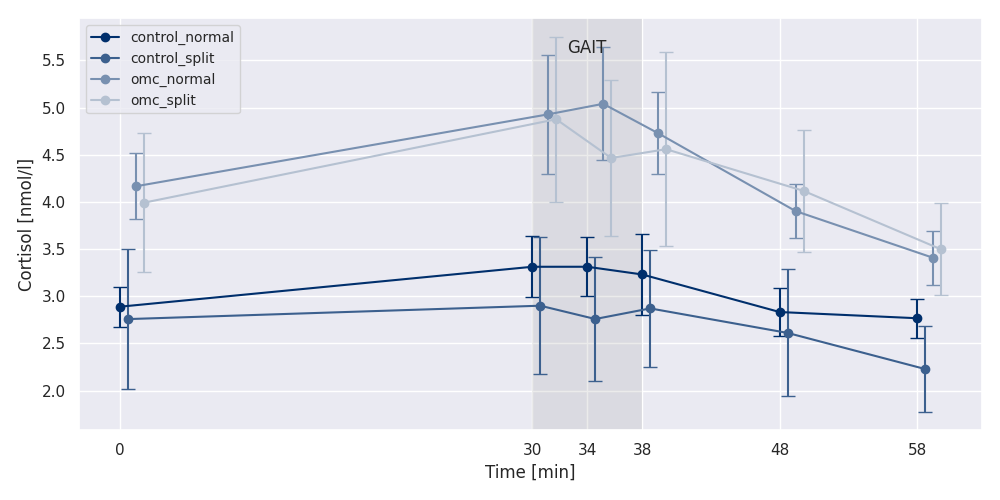

In [6]:
fig, ax = plt.subplots()

bp.protocols.plotting.saliva_plot(
    data=dataset.cortisol, saliva_type="cortisol", sample_times=dataset.sample_times, test_times=[30, 38], test_title="GAIT", sample_times_absolute=True, ax=ax
)

fig.tight_layout()

In [7]:
dataset.cortisol_features.groupby(["condition", "saliva_feature"]).mean().unstack("condition")

cortisol                                      
condition       control_normal control_split  omc_normal   omc_split
saliva_feature                                                      
auc_g               177.694695    159.068845  263.312485  260.932272
auc_i                10.102825     -0.905711   21.676365   19.625850
max_inc               0.906940      0.449255    1.462555    1.262905
max_inc_percent      33.447325     41.203223   37.626277   77.126762

In [8]:
pg.pairwise_tests(data=dataset.cortisol_features.xs("max_inc", level="saliva_feature").reset_index(), dv="cortisol", between="condition")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,condition,control_normal,control_split,False,True,0.910776,18.0,two-sided,0.374449,0.532,0.390101
1,condition,control_normal,omc_normal,False,True,-0.922246,18.0,two-sided,0.368598,0.535,-0.395014
2,condition,control_normal,omc_split,False,True,-0.286883,18.0,two-sided,0.777478,0.409,-0.122877
3,condition,control_split,omc_normal,False,True,-1.827378,18.0,two-sided,0.084271,1.218,-0.782697
4,condition,control_split,omc_split,False,True,-0.667889,18.0,two-sided,0.512678,0.465,-0.286068
5,condition,omc_normal,omc_split,False,True,0.158107,18.0,two-sided,0.876133,0.401,0.067720


In [9]:
hue_order = ["control", "omc"]

UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

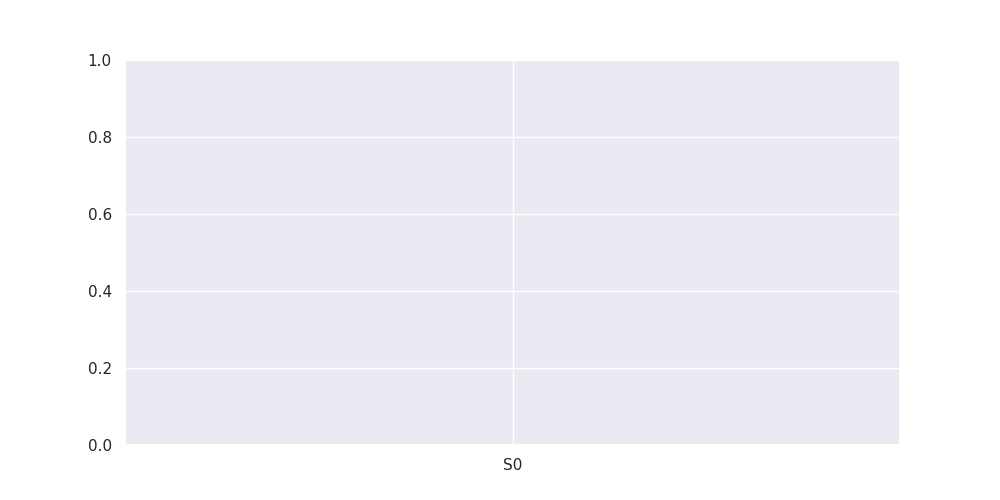

In [10]:
fig, ax = plt.subplots()

sns.boxplot(data=dataset.cortisol.reset_index(), x="sample", y="cortisol", hue="condition", hue_order=hue_order, ax=ax)
sns.swarmplot(data=dataset.cortisol.reset_index(), x="sample", y="cortisol", hue="condition", hue_order=hue_order, ax=ax, palette=cmaps.faculties[:2], dodge=True)

fig.tight_layout()

KeyError: 'control'

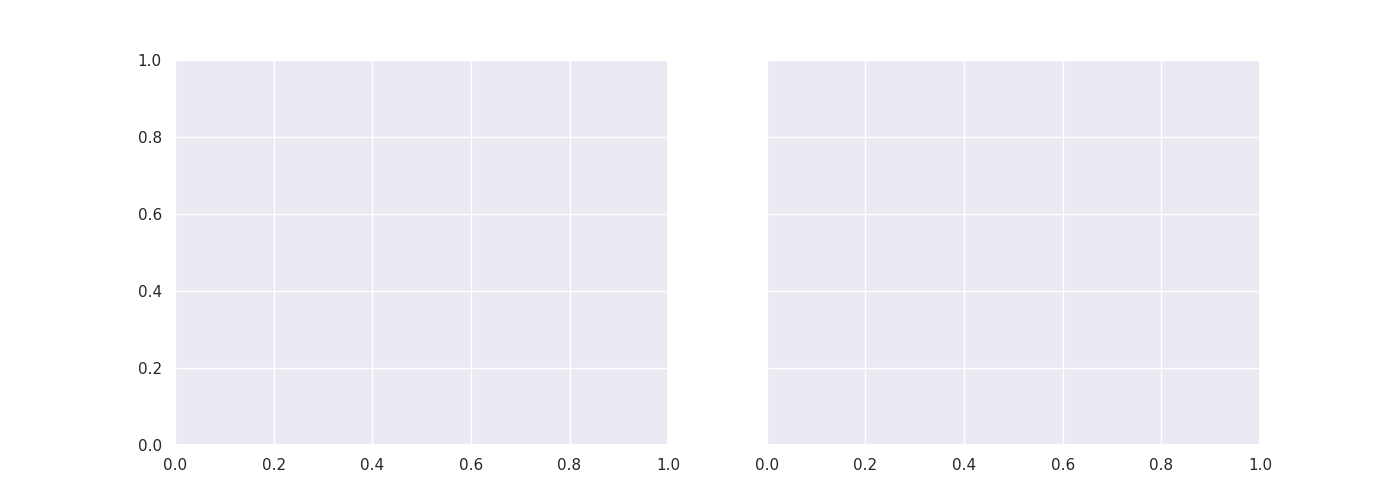

In [11]:
fig, axs = plt.subplots(figsize=(14,5), ncols=2, sharey=True)

dataset.cortisol.unstack()["cortisol"].xs("control", level="condition").T.plot(ax=axs[0], legend=False, title="Control")
dataset.cortisol.unstack()["cortisol"].xs("omc", level="condition").T.plot(ax=axs[1], legend=False, title="OMC")

#sns.lineplot(data=dataset.cortisol.reset_index(), x="sample", y="cortisol", ax=ax)

fig.tight_layout()

In [ ]:
dataset.cortisol_features.unstack()

In [ ]:
fig, ax = bp.protocols.plotting.saliva_multi_feature_boxplot(
    data=dataset.cortisol_features, saliva_type="cortisol", features=["max_inc", "auc_g"], hue="condition", hue_order=["control", "omc"], legend_orientation="horizontal", legend_loc="upper center"
)

fig.tight_layout(rect=(0,0,1,0.9))

In [ ]:
responder_list = dataset.cortisol.reindex(["S0", "S1"], level="sample").unstack().diff(axis=1).dropna(axis=1, how="all")
responder_list.columns = ["inc_S0S1"]
display(responder_list.groupby("condition").mean())

responder_list = responder_list > 1.5

display(responder_list)

responder_list.groupby("condition").value_counts()

In [ ]:
responder_list = dataset.cortisol_features.xs("max_inc", level="saliva_feature") > 1.5

display(responder_list)

responder_list.groupby("condition").value_counts()

In [ ]:
data = pd.read_csv(input_path.joinpath("stress_gait_labor.csv"))
data = data.assign(condition_fine=data["condition"].replace(condition_fine_mapping))
data = data.assign(condition=(data["condition_fine"].str.contains("OMC")).replace(condition_mapping))
data = data.set_index(["participant", "condition"])

data

In [ ]:
data = data.drop(index=["VP_03", "VP_04", "VP_09", "VP_14", "VP_21"], errors="ignore")

In [ ]:
data = convert_nan(data)
data.head()

In [ ]:
quest_dict = {
    "SSSQ-pre": data.filter(like="Pre_SSSQ").columns,
    "SSSQ-marker": data.filter(like="PreMocap_SSSQ").columns,
    "SSSQ-post": data.filter(like="Post_SSSQ").columns,
    "PANAS-pre": data.filter(like="Pre_PANAS").columns,
    "PANAS-marker": data.filter(like="PreMocap_PANAS").columns,
    "PANAS-post": data.filter(like="Post_PANAS").columns,
}

In [ ]:
quest_data = compute_scores(
    data=data,
    quest_dict=quest_dict,
    quest_kwargs={"PANAS-pre": {"language": "german"}, "PANAS-post": {"language": "german"}},
)

quest_data.head()

In [ ]:
panas_data_full = wide_to_long(quest_data, quest_name="PANAS", levels=["subscale", "time"])

omc_panas = panas_data_full.loc[pd.IndexSlice[:, "OMC", :, ["marker", "post"]]]
omc_panas = omc_panas.rename(index={"marker": "pre"})
control_panas = panas_data_full.loc[pd.IndexSlice[:, "Control", :, ["pre", "post"]]]

panas_data = pd.concat([omc_panas, control_panas]).sort_index()

panas_data.head()

In [ ]:
sssq_data_full = wide_to_long(quest_data, quest_name="SSSQ", levels=["subscale", "time"])

sssq_omc = sssq_data_full.loc[pd.IndexSlice[:, "OMC", :, ["marker", "post"]]]
sssq_omc = sssq_omc.rename(index={"marker": "pre"})
sssq_control = sssq_data_full.loc[pd.IndexSlice[:, "Control", :, ["pre", "post"]]]

sssq_data = pd.concat([sssq_omc, sssq_control]).sort_index()
sssq_data.head()

In [ ]:
for key, data in panas_data_full.xs("OMC", level="condition").groupby("subscale"):
    display(key)
    results = pg.pairwise_tests(data=data.reset_index(), dv="PANAS", subject="participant", within="time")
    display(results.round(3))

In [ ]:
fig, ax = plt.subplots()

sns.boxplot(
    data=sssq_data_full.xs("OMC", level="condition").reset_index(),
    x="subscale",
    y="SSSQ",
    hue="time",
    hue_order=["pre", "marker", "post"],
    ax=ax,
)

fig.tight_layout()

In [ ]:
sssq_diff = (
    sssq_data.unstack()
    .reindex(["pre", "post"], level="time", axis=1)
    .diff(axis=1)
    .dropna(axis=1, how="all")
    .droplevel(level=-1, axis=1)
)

sssq_diff

In [ ]:
panas_diff = (
    panas_data.unstack()
    .reindex(["pre", "post"], level="time", axis=1)
    .diff(axis=1)
    .dropna(axis=1, how="all")
    .droplevel(level=-1, axis=1)
)

panas_diff

In [ ]:
fig, ax = plt.subplots()

sns.boxplot(data=sssq_diff.reset_index(), y="SSSQ", x="subscale", hue="condition", hue_order=["Control", "OMC"], ax=ax)

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()

sns.boxplot(
    data=panas_diff.reset_index(), y="PANAS", x="subscale", hue="condition", hue_order=["Control", "OMC"], ax=ax
)

fig.tight_layout()

## Plot for ISB Abstract

In [ ]:
panas_data_full.to_csv(input_path.joinpath("panas_data.csv"))

In [ ]:
panas_data = pd.read_csv(input_path.joinpath("panas_data.csv"))
panas_data = panas_data.set_index(["participant", "condition", "subscale", "time"])
panas_data

In [ ]:
panas_data = panas_data.loc[pd.IndexSlice[:, "OMC", "NegativeAffect"]]

In [ ]:
from biopsykit.stats import StatsPipeline

In [ ]:
pipeline = StatsPipeline(
    steps=[("test", "pairwise_tests")], params={"dv": "PANAS", "subject": "participant", "within": "time"}
)

pipeline.apply(panas_data)

box_pairs, pvalues = pipeline.sig_brackets("test", stats_effect_type="within")

pipeline.display_results()

In [ ]:
fig, ax = plt.subplots()

bp.plotting.feature_boxplot(
    data=panas_data.reset_index(),
    x="time",
    y="PANAS",
    hue="time",
    show_legend=False,
    order=["pre", "marker", "post"],
    stats_kwargs={"pairs": box_pairs, "pvalues": pvalues, "verbose": 0},
    ax=ax,
)

fig.tight_layout()